In [2]:
# ✅ Final Machine Learning Project Code: Predicting Player Sustainability Score

# --- Import libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
# --- Load and prepare data ---
data = pd.read_csv('data_with_all_scores_scaled.csv')
data['missing_market_value'] = data['missing_market_value'].astype(int)

features = ['ASR', 'Age_norm', 'MarketValue_norm', 'Transfers_norm', 'Nationality_norm', 'ClubTier_norm']
target = 'SustainabilityScore'

print("\nMissing values before dropping:")
print(data[features + [target]].isnull().sum())
data = data.dropna(subset=features + [target])

X = data[features]
y = data[target]
X = X[data['missing_market_value'] == 0]
y = y[data['missing_market_value'] == 0]


Missing values before dropping:
ASR                    0
Age_norm               0
MarketValue_norm       0
Transfers_norm         0
Nationality_norm       0
ClubTier_norm          0
SustainabilityScore    0
dtype: int64


In [4]:
# Show first few rows to understand the data
print("First 5 rows of the data:")
print(data.head())

First 5 rows of the data:
          Player Name  Age                 Team   ASR Nationality  \
0          Abdu Conté   27           Young Boys  6.58         POR   
1  Abduqodir Khusanov   21      Manchester City  7.01         UZB   
2           Abel Ruiz   25            Girona FC  6.65         ESP   
3       Achraf Hakimi   26  Paris Saint-Germain  7.63         MAR   
4         Adam Daghim   19    Red Bull Salzburg  6.97         DEN   

   Transfer History Count  MarketValue  missing_market_value  Age_norm  \
0                       5       750000                     0    0.7075   
1                       3     11400000                     0    0.5725   
2                       5      5700000                     0    0.6625   
3                       5     62000000                     0    0.6850   
4                       4      5400000                     0    0.5275   

   MarketValue_norm  Transfers_norm  Nationality_norm  ClubTier  \
0          0.103041            0.40            

In [5]:
# --- Split data ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# --- Train Random Forest Regressor ---
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"\n📊 Random Forest Performance:\nMSE: {mse_rf:.4f}\nR²: {r2_rf:.4f}")


📊 Random Forest Performance:
MSE: 0.2327
R²: 0.9868


In [7]:
# --- Cross-Validation ---
cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='r2')
print(f"\n🌀 CV R² Scores: {cv_scores}")
print(f"Mean CV R²: {cv_scores.mean():.4f}, Std: {cv_scores.std():.4f}")


🌀 CV R² Scores: [0.99047036 0.99300208 0.98015707 0.99099434 0.98762871]
Mean CV R²: 0.9885, Std: 0.0045


In [8]:
# --- Save model ---
joblib.dump(rf_model, 'sustainability_rf_model.pkl')

['sustainability_rf_model.pkl']

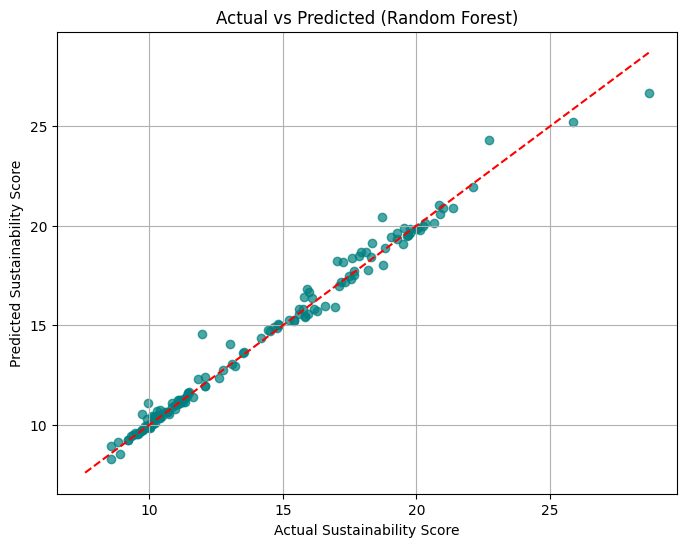

In [9]:
# --- Plot actual vs predicted ---
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_rf, alpha=0.7, color='teal')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Actual Sustainability Score")
plt.ylabel("Predicted Sustainability Score")
plt.title("Actual vs Predicted (Random Forest)")
plt.grid(True)
plt.show()

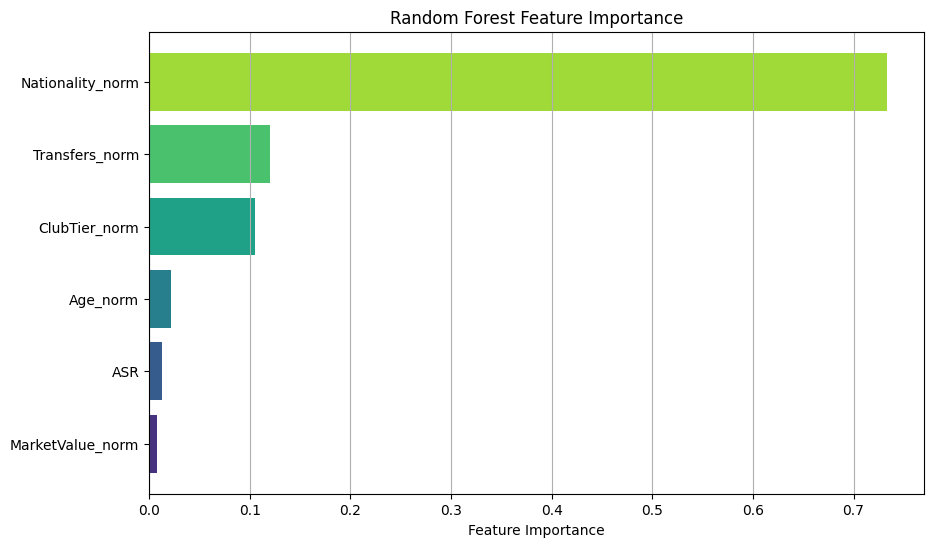

In [10]:
# --- Feature Importance ---
importances = rf_model.feature_importances_
fi_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance')

plt.figure(figsize=(10,6))
plt.barh(fi_df['Feature'], fi_df['Importance'], color=sns.color_palette('viridis', len(features)))
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.grid(axis='x')
plt.show()

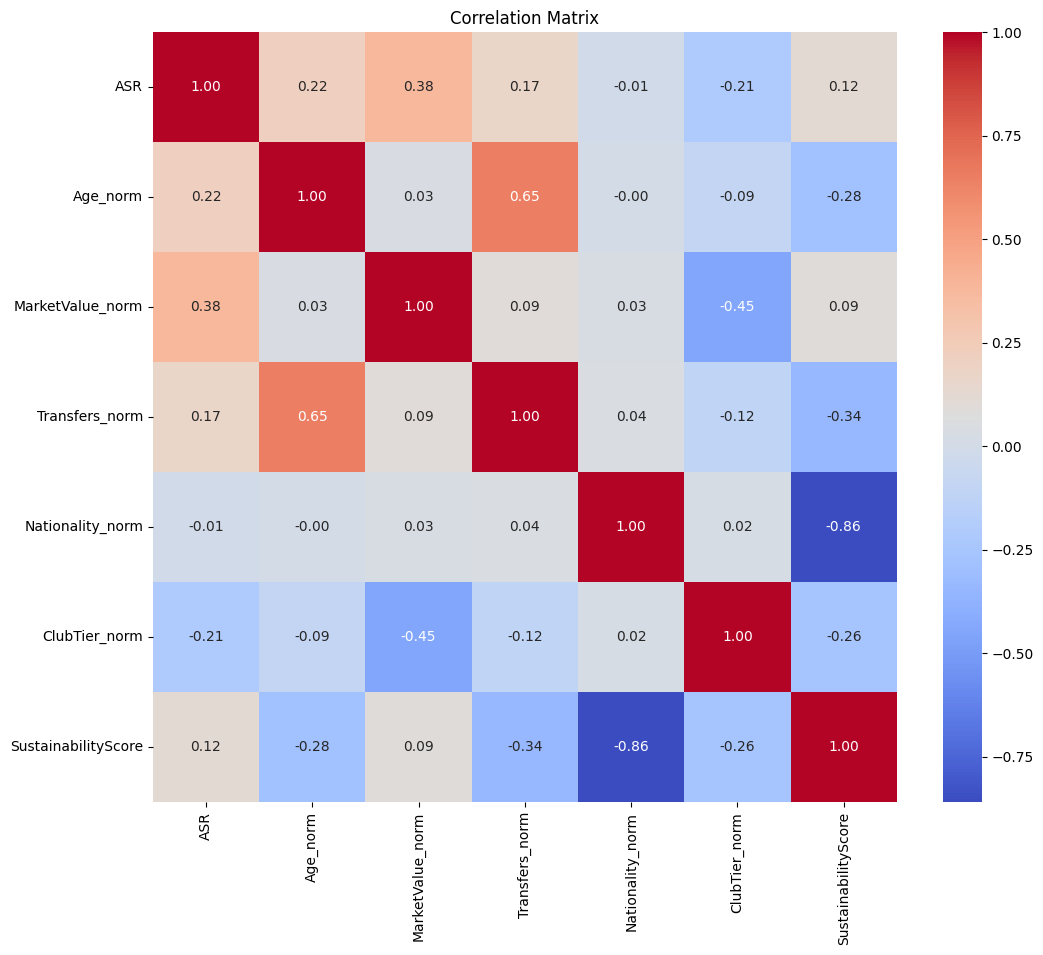

In [11]:
# --- Correlation Heatmap ---
plt.figure(figsize=(12,10))
sns.heatmap(data[features + [target]].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()

In [12]:
# --- Manual Sustainability Evaluation Function ---
def normalize(val, min_val, max_val):
    return 0.1 + 0.9 * ((val - min_val) / (max_val - min_val))

def evaluate_player_sustainability(asr, age, market_value, transfers, nationality, club_tier, model):
    age_n = normalize(age, 0, 40)
    mv_n = normalize(market_value, 0, 222_000_000)
    tr_n = normalize(transfers, 0, 15)
    nat_n = 0.1 if nationality.lower() == 'european' else 1.0
    tier_n = normalize(club_tier, 1, 3)

    input_score = 0.2*age_n + 0.04*mv_n + 0.32*tr_n + 0.28*nat_n + 0.16*tier_n
    manual_score = asr / input_score

    new_df = pd.DataFrame([{
        'ASR': asr,
        'Age_norm': age_n,
        'MarketValue_norm': mv_n,
        'Transfers_norm': tr_n,
        'Nationality_norm': nat_n,
        'ClubTier_norm': tier_n
    }])

    predicted = model.predict(new_df)[0]

    print("\n🔍 New Player Evaluation")
    print(f"Manual Score: {manual_score:.2f}, ML Prediction: {predicted:.2f}")
# --- Example evaluation ---
evaluate_player_sustainability(
    asr=7.36,
    age=26,
    market_value=62000000,
    transfers=5,
    nationality='moroccan',
    club_tier=1,
    model=rf_model
)


🔍 New Player Evaluation
Manual Score: 12.80, ML Prediction: 11.89



📋 Model Comparison:
               Model       MSE        R2
0      Random Forest  0.232651  0.986808
1  Linear Regression  0.998762  0.943366
2                SVR  4.499264  0.744872


C:\Users\ibrah\AppData\Local\Temp\ipykernel_7280\3106254845.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results, x='Model', y='R2', palette='muted')


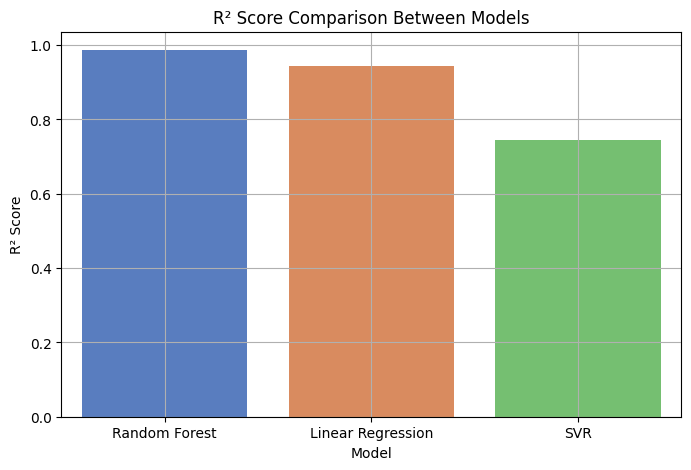

In [14]:
# --- Compare with other models ---
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

svr_model = SVR()
svr_model.fit(X_train, y_train)
y_pred_svr = svr_model.predict(X_test)

results = pd.DataFrame({
    'Model': ['Random Forest', 'Linear Regression', 'SVR'],
    'MSE': [mse_rf, mean_squared_error(y_test, y_pred_lr), mean_squared_error(y_test, y_pred_svr)],
    'R2': [r2_rf, r2_score(y_test, y_pred_lr), r2_score(y_test, y_pred_svr)]
})

print("\n📋 Model Comparison:")
print(results)

plt.figure(figsize=(8,5))
sns.barplot(data=results, x='Model', y='R2', palette='muted')
plt.title("R² Score Comparison Between Models")
plt.ylabel("R² Score")
plt.grid(True)
plt.show()